# Neighborhoods in Toronto



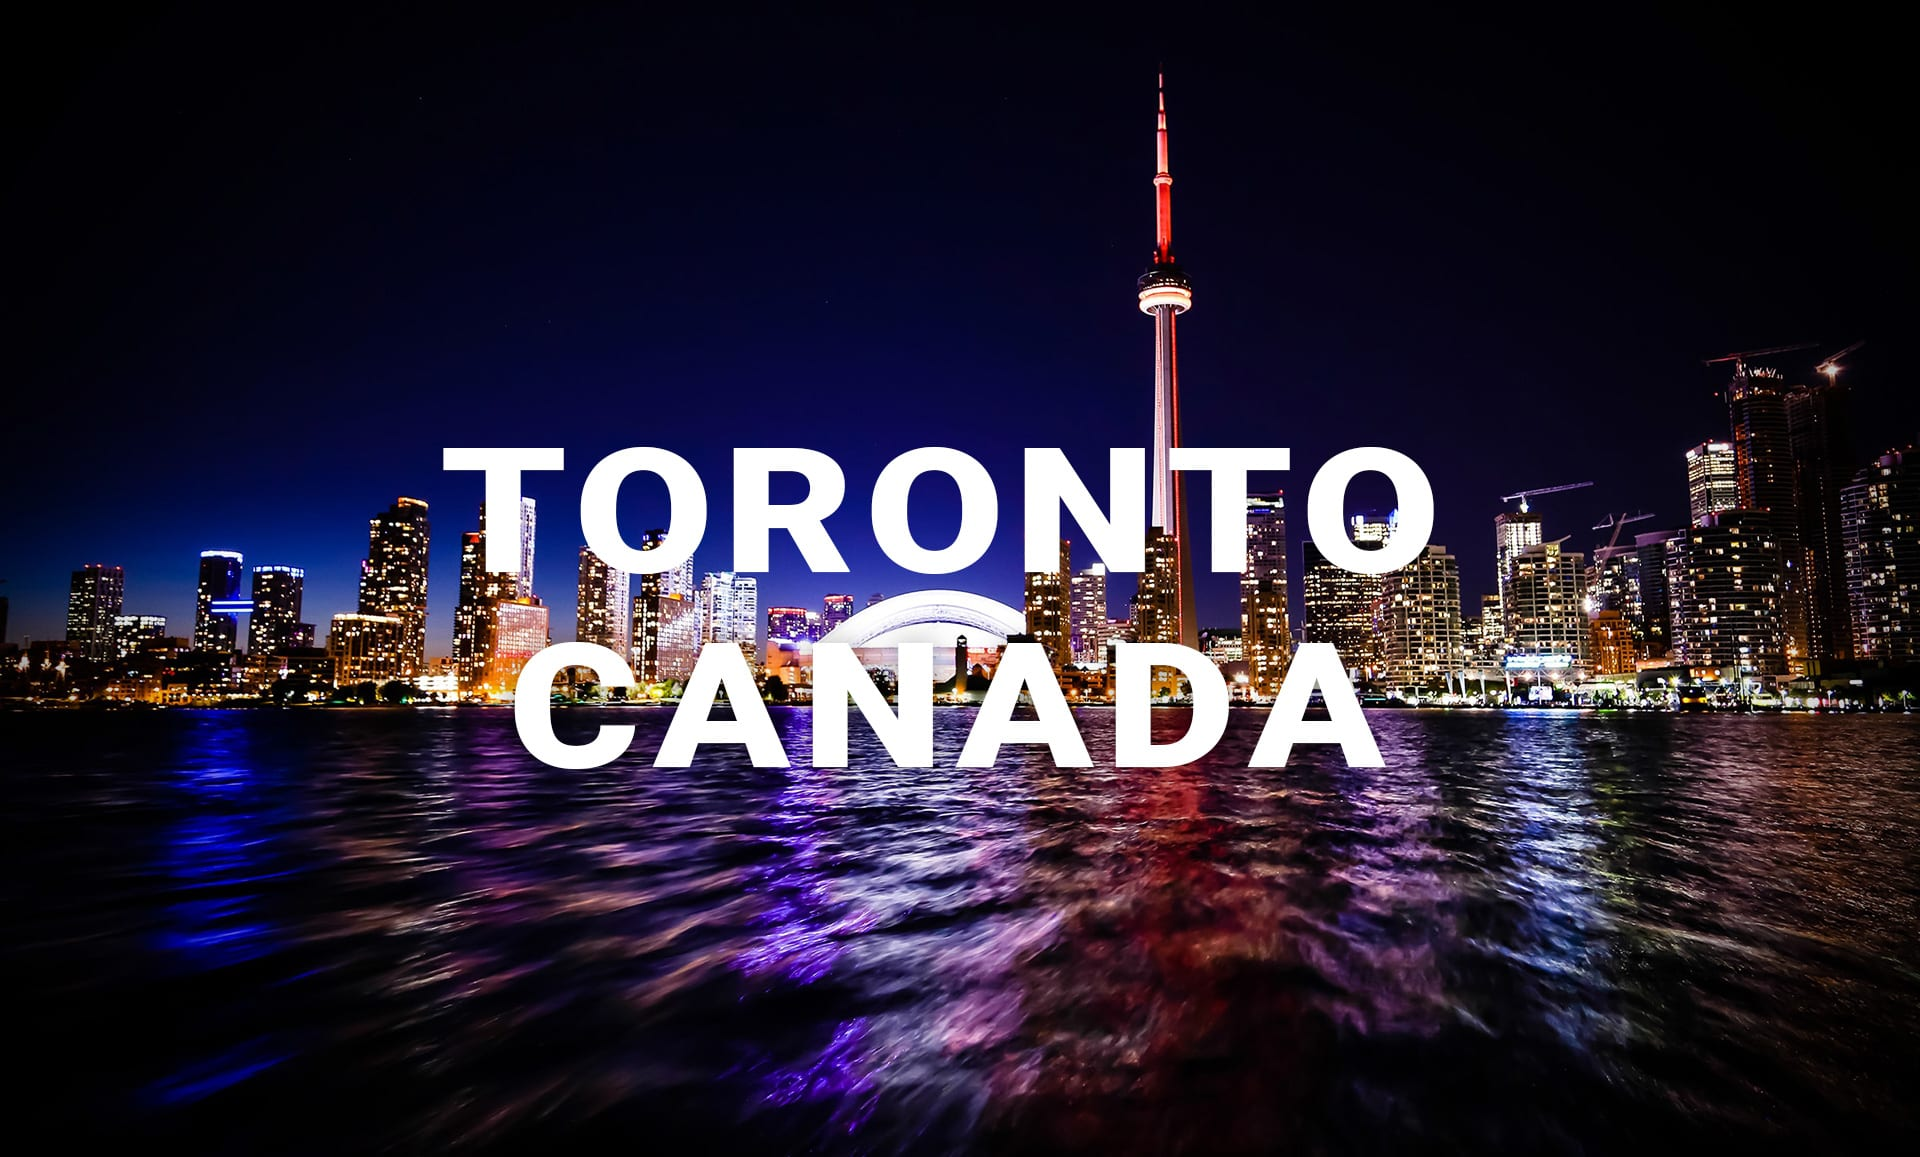

In [0]:
from IPython.display import Image
Image(filename='toronto.jpg',width=800, height=400)

# **Postal codes clustering of the city of Toronto, Canada, using the venues density**
**Introduction**

In this project is presented the segmentation and clustering of the Postal codes division of the city of Toronto in the province of Ontario, Canada, extracted from "List of postal codes of Canada: M" in Wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M).

The Foursquare API was used to find the venues on each postal code zone using a radius based on the area cover by each postcode without overlapping between them and a maximum number of venues per postal code of 100. Using K-Means clustering algorithm, the postal codes were grouped based on the venues density (venues/area) and the result was showed on a map of Toronto.

In [1]:

import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Extract data of Toronto neighborhoods from Wikipedia


In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_result = requests.get(url).text #get the entire html of the article as a str
html_parsed_result = BeautifulSoup(text_result, 'html.parser') #transform the text to html

neightborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neightborhood_rows = neightborhood_info_table.find_all('tr')

# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
neightborhood_info = []
for row in neightborhood_rows:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    neightborhood_info.append(info)
    
neightborhood_info[0:5]

[['Postal Code', '', 'Borough', '', 'Neighborhood'],
 ['M1A', '', 'Not assigned', '', ''],
 ['M2A', '', 'Not assigned', '', ''],
 ['M3A', '', 'North York', '', 'Parkwoods'],
 ['M4A', '', 'North York', '', 'Victoria Village']]


Transform the data into a pandas dataframe

In [3]:
neightborhood_info[0][-1] = 'Neighborhood' # change to american spelling
df_neighborhood = pd.DataFrame(neightborhood_info[1:], columns=neightborhood_info[0])

df_neighborhood.head(5)

,Postal Code,,Borough,,Neighborhood
0,M1A,,Not assigned,,
1,M2A,,Not assigned,,
2,M3A,,North York,,Parkwoods
3,M4A,,North York,,Victoria Village
4,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"


 Explore and clean neighborhoods dataset

 The data returned has missing info like "Not assigned" boroughs and neighborhoods.




In [4]:
print('Before cleaning the DataFrame, its new shape is {}'.format(df_neighborhood.shape))


Before cleaning the DataFrame, its new shape is (180, 5)


In [5]:
boroughs_index = df_neighborhood.index[df_neighborhood['Borough'] == 'Not assigned']
nneighborhoods_index = df_neighborhood.index[df_neighborhood['Neighborhood'] == 'Not assigned']
df_neighborhood.drop(df_neighborhood.index[boroughs_index], inplace=True)
df_neighborhood.drop(df_neighborhood.index[nneighborhoods_index], inplace=True)

df_neighborhood.reset_index(drop=True, inplace=True)

df_neighborhood.head(10)

,Postal Code,,Borough,,Neighborhood
0,M3A,,North York,,Parkwoods
1,M4A,,North York,,Victoria Village
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights"
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government"
5,M9A,,Etobicoke,,Islington Avenue
6,M1B,,Scarborough,,"Malvern, Rouge"
7,M3B,,North York,,Don Mills
8,M4B,,East York,,"Parkview Hill, Woodbine Gardens"
9,M5B,,Downtown Toronto,,"Garden District, Ryerson"


In [6]:
#The "Not assigned" values in the Neighborhood column will be replace with the Borough name in that cell

NAN = df_neighborhood.index[df_neighborhood['Neighborhood'] == 'Not assigned'] # run this again because the indexes on the dataframe where reset

for idx in NAN:
    df_neighborhood['Neighborhood'][idx] = df_neighborhood['Borough'][idx]
    
df_neighborhood.head(10)

,Postal Code,,Borough,,Neighborhood
0,M3A,,North York,,Parkwoods
1,M4A,,North York,,Victoria Village
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights"
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government"
5,M9A,,Etobicoke,,Islington Avenue
6,M1B,,Scarborough,,"Malvern, Rouge"
7,M3B,,North York,,Don Mills
8,M4B,,East York,,"Parkview Hill, Woodbine Gardens"
9,M5B,,Downtown Toronto,,"Garden District, Ryerson"


In [7]:
print('After cleaning the DataFrame, its new shape is {}'.format(df_neighborhood.shape))


After cleaning the DataFrame, its new shape is (103, 5)


In [0]:
print('  {} Postal codes'.format(df_neighborhood['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(df_neighborhood['Borough'].unique().shape[0]))
print('  {} Neighborhoods'.format(df_neighborhood['Neighborhood'].unique().shape[0]))

  102 Postal codes
  10 Boroughs
  207 Neighborhoods


In [0]:
#The dataframe has 102 Postal codes but it has 212 rows, because each Postal code can present more than one neighborhood (207 in total). 
#Therefore, the dataframe should be group by the Postal code, ending with a dataframe with 102 rows.



group = df_neighborhood.groupby('Postcode')
groupe_neighborhood = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
groupe_borough  = group['Borough'].apply(lambda x: set(x).pop())
groupe = pd.DataFrame(list(zip(groupe_borough.index, groupe_borough, groupe_neighborhood)))
groupe.columns = ['Postcode', 'Borough', 'Neighborhood']

groupe.head(10)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [0]:
#The shape of the final version of the dataframe 
groupe.shape

(102, 3)

Importing Geographical Coordinates into the Dataframe

In [0]:
url1 = "http://cocl.us/Geospatial_data"

data_G = pd.read_csv(url1)
data_G.columns = ['PostalCode', 'Latitude', 'Longitude']
data_G.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging both the dataframes in one single dataframe

In [0]:
df = groupe.join(data_G.set_index('PostalCode'), on='Postcode')
df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [0]:
#Selecting Boroughs with 'Toronto' in their name
dt = df[df['Borough'].str.contains("Toronto")]
dt.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
36,M4E,East Toronto,The Beaches,43.676357,-79.293031
40,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
41,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
42,M4M,East Toronto,Studio District,43.659526,-79.340923
43,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


**Data Visualization** 

With the coordinates of each postal code, a map of Toronto with markers indicating the Postcode position is generated



In [0]:
#Retrieving coordinates for Toronto.
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
 
loc_geo = Nominatim(user_agent="toronto_explorer")
location = loc_geo.geocode('Toronto, Toronto')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))



The geograpical coordinate of Downtown Toronto are 43.653963, -79.387207.


In [0]:
map = folium.Map(location=[43.653963, -79.387207], zoom_start=11)

for location in dt.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

FourSquare API Credentials

In [0]:
# your Foursquare ID
CLIENT_ID = '2J3XO1E0RDBSF4AC0TLAN40ATHSOPQHCBOAP2E5YHMSKIJBG' 
# your Foursquare Secret
CLIENT_SECRET = '12NM3DUM3301G405FRFYFS4JHTDWSUD0SXN32IPXOK1HANUC' 
# Foursquare API version
VERSION = '20180605' 

In [0]:
def get_Venues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [0]:
#function call for toronto_data

toronto_venues = get_Venues(names=dt['Neighborhood'],
                                   latitudes=dt['Latitude'],
                                   longitudes=dt['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

In [0]:
#toronto_venues shape


print(toronto_venues.shape)
toronto_venues.head()

(1717, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Glen Stewart Park,43.675278,-79.294647,Park
3,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [0]:
#Grouping according to neighborhood


toronto_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,58,58,58,58,58,58
"Brockton, Exhibition Place, Parkdale Village",24,24,24,24,24,24
Business Reply Mail Processing Centre 969 Eastern,18,18,18,18,18,18
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",48,48,48,48,48,48
Central Bay Street,85,85,85,85,85,85
"Chinatown, Grange Park, Kensington Market",86,86,86,86,86,86
Christie,18,18,18,18,18,18


In [0]:
#OneHot encoding for the categorical values


# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
col_list = list(toronto_onehot.columns)
col_list.remove('Neighborhood')
cols = ['Neighborhood'] + [col for col in col_list]

toronto_onehot = toronto_onehot[cols]
toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Transportation Service,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [0]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

toronto_groupe = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_groupe.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Transportation Service,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,0.0,0.010000,0.0,0.03,0.000000,0.000000,0.0,0.000000,0.020000,0.0,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.01,0.000000,0.01,0.030000,0.000000,0.0,0.01,0.02,0.010000,0.0,0.000000,0.040000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.01,0.000000,0.070000,0.0,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.03,0.0,0.000000,0.0,0.0,0.01,0.01,0.010000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.02,0.0,0.0,0.

###Cluster Neighborhoods


In [0]:
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [0]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_groupe['Neighborhood']

for ind in np.arange(toronto_groupe.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = most_common_venues(toronto_groupe.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Bar,Café,Steakhouse,Asian Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Steakhouse,Café
2,"Brockton, Exhibition Place, Parkdale Village",Nightclub,Breakfast Spot,Café,Coffee Shop,Gym
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Fast Food Restaurant,Park,Pizza Place,Recording Studio
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Terminal,Airport Lounge,Boutique,Bar,Coffee Shop


In [0]:
# set number of clusters
kclusters = 5

toronto_groupe_clustering = toronto_groupe.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_groupe_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:40]

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       2, 1, 4, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 2, 2, 1], dtype=int32)

In [0]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dt

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
36,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Pub,Park,Health Food Store,Trail,Dumpling Restaurant
40,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store
41,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,2,Gym,Park,Brewery,Burger Joint,Burrito Place
42,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Brewery,Gastropub,Bakery
43,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2,Lake,Park,Swim School,Bus Line,Dim Sum Restaurant


In [0]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [0]:
#Examine Clusters

toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
49,Downtown Toronto,0,Park,Playground,Trail,Dessert Shop,Event Space
63,Central Toronto,0,Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio


In [0]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
62,Central Toronto,3,Garden,Yoga Studio,Dim Sum Restaurant,Farmers Market,Falafel Restaurant
